### ECE/CS/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2022 ###


# Madison Bus Route Designing: Preliminary Report

Team Members: Rabeeya Hamid, Ai Guan, Naman Gupta

Data: 04/22/2022

*****

### Table of Contents

1. [Problem Description](#1.-Problem-Description)
2. [Data Collection](#2.-Data-Collection)
3. [Mathematical Model](#3.-Mathematical-Model)
4. [Preliminary Code Implementation](#4.-Code-Implementation)
5. [Preliminary Results and Analysis](#5.-Results-and-Analysis)


In [783]:
using PyPlot

## 1. Problem Description


Based on the increasing need of public transportation, the City of Madison Metro Transit is proposing a major network redesign ([Transit Network Redesign](https://www.cityofmadison.com/metro/routes-schedules/transit-network-redesign)). Currently, they are surveying the students of UW-Madison and the residents of Madison for suggestions on their travel preferences, so that they can re-design the bus routes to meet the ridership demand and businesses. As University of Wisconsin-Madison students, our team thinks the redesign project would also have significant impact on our daily lives. 

The aim of the project is to model the routing design as a network optimization problem, so that we can propose the model as a part of their feedback survey. The family of network optimization problem includes assignment, critical path, max flow, shortest path, transportation, and min-cost flow problems. One of the primary results of the model is a network of arcs and nodes that illustrate the optimal routes for the nodes in a network ([Network Optimization](http://home.ubalt.edu/ntsbarsh/opre640a/partIII.htm#:~:text=The%20family%20of%20network%20optimization,called%20a%20vertex%2C%20or%20point)).

The project is a transportation problem in the network optimization problem family, and the nodes represent the bus stops, and the arcs represent the transportation flow between two stations. The model consist of three parts: decision variables, constraints, and objective function. We would like to model the optimal routes to meet the demand of ridership for each bus stop in Madison. Therefore, the objective function of the problem is to maximize the number of passengers boarding each bus on all the bus stops in Madison,  subject to fuel limitation of each bus, the capacity of a bus, routing regulations and ridership demand for each bus stop. 

## 2. Data Collection

The data utilized in the project is the publicly available data from the City of Madison website. Two datasets are selected corresponding to the 
   1.	Metro Transit Ridership by Stop | City of Madison Open Data.  [Data Source](https://data-cityofmadison.opendata.arcgis.com/datasets/cityofmadison::metro-transit-ridership-by-stop)
   2.	Metro Transit Bus Route Patterns | City of Madison Open Data. [Data Source](https://data-cityofmadison.opendata.arcgis.com/datasets/cityofmadison::metro-transit-bus-route-patterns/about)
   3.   Metro Transit Bus Stops | City of Madison Open Data. [Data Source](https://data-cityofmadison.opendata.arcgis.com/maps/metro-transit-bus-stops)
    4. Metro Transit Trips | City of Madison Open Data. [Data Source](https://data-cityofmadison.opendata.arcgis.com/datasets/cityofmadison::metro-transit-bus-route-trips)

* The first dataset contains a list of all the bus stops, their geographical location (longitude and latitude) and the ridership at that bus stop averaged over 12 days. We do not have distances between these bus stops, nor do we have connections between them, for which we propose the following approach. 
   *   We calculate the Geodesic Euclidean distance between the geographic position of the bus stops to define the distances between them. 
   *   These distances will be multiplied by a constant of proportionality to determine the fuel cost associated with each path. 

* The second dataset contains a list of present bus routes, the bus stops along the routes and the total ridership for the bus routes averaged over 12 days. 
    
* The third dataset maps the bus stops to the bus routes taken by all the buses in Madison. 
* The fourth dataset maps the bus routes to the bus stops 

Further, we load all the data and calculate the euclidean distance between each bus stop in Madison. We give a brief demo - 

In [784]:
# import Pkg;
# using Pkg
# Pkg.add("Cbc");
# Pkg.add("GraphRecipes");
# Pkg.add("LightGraphs");
# Pkg.add("SimpleWeightedGraphs");
# Pkg.add("SparseArrays");
# Pkg.add("CSV");
# Pkg.add("DataFrames");
# Pkg.add("Geodesy");

In [785]:
using JuMP, Plots, Cbc, GraphRecipes, LightGraphs, SimpleWeightedGraphs, SparseArrays

using CSV
using DataFrames

# import data set as a dataframe

# 1
ridership_data = CSV.read("data/Metro_Transit_Ridership_by_Stop.csv", DataFrame)
# 2
route_patterns_data = CSV.read("data/Metro_Transit_Bus_Route_Patterns.csv", DataFrame)
# 3
stops_data = CSV.read("data/Metro_Transit_Bus_Stops.csv", DataFrame)
# 4
weekday_data = CSV.read("data/Metro_Transit_Ridership_by_Route_Weekday.csv", DataFrame)
;

In [786]:
N = size(ridership_data,1)

2142

### Calculating distances between all bus stops:

The distance between each bus stop in Madison as a $n * n$ matrix.

We map the bus stops (ids) to bus routes  that will help us model the optimal bus routes.

In [787]:
stop_route = Dict()

for i in eachrow(stops_data)
        if i.Route != "None"
            stop_route[i.stop_id] = [parse(Int, d) for d in split(i.Route,",")] 
        end
end

In [788]:
bus_route = [80, 15, 4]

route_stops = []

for (s, r) in stop_route
    for x in bus_route
        if x in r
            append!(route_stops, s)
        end
    end 
end

length(route_stops)

278

In [789]:
using Geodesy

# TODO: Create a function for generating a distance matrix

# stops = Vector{LatLon{Float64}}()
stops = []

stop_locations = Vector{LatLon{Float64}}()
intersections = []
stop_ids = []

for i in eachrow(ridership_data)
    int = i.IntersectionID
    if i.StopID in route_stops
    if int ∉ intersections
        push!(intersections, int)
        x = LatLon(i.Lat, i.Lon)
        push!(stop_locations, x)
        push!(stop_ids, i.StopID)
    end
    end
end

N = length(stop_ids)

distances = zeros(N,N)

for i in 1:N
    for j in 1:N
        distances[i,j] = euclidean_distance(stop_locations[i], stop_locations[j])
    end
end

distances
stop_locations

lat = [x.lat for x in stop_locations][1:N-2]
long = [x.lon for x in stop_locations][1:N-2]

length(lat),length(long)

(138, 138)

Creating $n*n$ Adjacency Matrix on the basis of StopIDs. We assume a bus stop with StopID 5 is connected to StopID 6.

In [790]:
maximum(distances)

16353.222335102404

In [791]:
# N = size(ridership_data,1)
# N = 47
Adj = zeros(N,N)

index_stopid = Dict()

for row in eachrow(ridership_data)
    if row.StopID in route_stops
        i = rownumber(row)
        index_stopid[i] = row.StopID
    end
end
index_stopid
for i in 1:N
    if i + 1 < N
        Adj[i, i + 1] = 1
        # Adj[i + 1, i] = 1
    end
end

using Distributions


for i in 1:N
    for j in 1:N
        if i != j
        d = distances[i,j]
            if d > 2000
                Adj[i, j] = 0
                Adj[j, i] = 0
            end
#             else
#                 norm = d / 500

#                 prob = Binomial(1,norm)

#                 p = rand(prob, 1)[1]

#                 if p == 0
#                     p = rand((0,1))
#                     Adj[i, j] = p
#                     Adj[j, i] = 1-p
#                     # Adj[i, j] = 1
#                     # Adj[j, i] = 0
#                 else
#                     Adj[i, j] = 0
#                     Adj[j, i] = 0

#                 end


                if d < 300
                    p = rand((0,1))
                    Adj[i, j] = p
                    Adj[j, i] = 1-p
                end

            # end
        end
    end
end


# # Adj
# # reshape(Adj, (n-1, n-1))


Adj = Adj[1:N-2,1:N-2]
# # D = distances[1:N-1,1:N-1]
# ;

D = distances[1:N-2,1:N-2]
# index_stopid

138×138 Matrix{Float64}:
    0.0     770.656   794.924   939.284  …  7862.2     9007.23   8219.56
  770.656     0.0     510.88    239.555     8354.57    9592.79   8714.46
  794.924   510.88      0.0     422.602     8634.52    9800.31   8992.86
  939.284   239.555   422.602     0.0       8593.8     9827.02   8953.65
  567.934   439.384   824.767   678.445     7915.35    9157.52   8275.21
  606.094   275.601   685.385   514.283  …  8079.55    9318.52   8439.39
  266.902   616.788   532.066   735.797     8127.58    9273.47   8485.11
  597.23    555.365   218.343   558.534     8455.69    9603.33   8813.42
 1235.28    668.024   470.385   434.76      9005.17   10211.8    9364.62
  526.701   297.054   370.36    415.225     8288.22    9480.2    8647.13
 3643.91   4150.74   3711.28   4132.5    …  9519.06   10030.3    9834.58
 1995.25   2427.85   1979.56   2401.18      8946.69    9769.7    9287.76
  932.39   1473.58   1132.01   1514.66      8269.66    9255.42   8620.25
    ⋮                     

In [792]:
Adj

138×138 Matrix{Float64}:
 0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [793]:
norm = 100 / maximum(distances)
            
prob = Binomial(1,norm)

p = rand(prob, 1)[1]

0

In [794]:
ridership = Dict()

for i in eachrow(weekday_data)
    if i.StopID in stop_ids
        ridership[i.StopID] = i.DailyBoardings
    end
end


In [795]:
r = collect(values(ridership))

138-element Vector{Any}:
 322.93
   9.47
   0.45
  71.81
  91.83
 179.85
   1.67
  10.52
  10.61
  10.13
  35.57
  14.03
   9.12
   ⋮
  25.72
  35.52
   3.58
   2.33
   4.67
   0.56
  10.7
   0.89
   0.11
   4.56
 105.85
  17.18


## 3. Mathematical Model

For the preliminary report, our focus is to generate an illustrative demo of the model. It is a smaller bus network which consists of 8 bus stations.

### Parameters Given:
- Number of bus stops ```n``` : number of nodes in our network
- Adjacency Matrix ```Adj``` ($n \times n$) : describes connections between bus stops
- Distance Matrix ```D``` ($n \times n$): Euclidean distances between all bus stops
- Ridership vector ```r```($n \times 1$): the ridership demand at every bus stop
- Start node ```n_i```: the bus stop from where our bus starts
- End node ```n_e```: the bus stop where our bus route ends
- Distance (Fuel) limit ```f```: the distance our bus can travel in total
- Number of buses ```num_buses```: the total number of buses running in our model

In [796]:
num_buses = 3

3

### Practice Data:

In [797]:
# n = 13

# Adj = [0 0 0 0 1 0 1 1 0 1 0 1 1;
#        0 0 1 0 0 1 0 0 1 0 1 0 0;
#        1 0 0 0 0 0 1 0 0 0 1 1 0;
#        0 0 0 0 1 0 0 1 1 0 1 0 1;
#        0 0 0 0 0 0 1 0 0 0 0 0 0;
#        0 0 0 1 0 0 0 0 0 1 0 0 0;
#        0 0 0 0 0 0 0 0 0 0 0 1 0; 
#        1 0 0 1 0 0 1 0 1 0 1 0 1;
#        0 1 0 0 0 1 0 0 0 0 0 0 0;
#        1 0 0 1 1 0 1 1 0 0 1 0 0;
#        1 0 0 0 0 0 1 0 0 0 0 0 0;
#        0 0 0 0 1 0 0 1 1 0 0 0 1;
#        0 0 0 0 0 0 1 0 0 0 1 0 0]

# D = [0 4 6 3 1 1 8 1 4 1 8 4 1;
#      5 0 2 6 5 5 4 6 1 4 2 8 9;
#      1 8 0 4 2 7 2 3 4 2 7 2 3;
#      7 2 3 0 4 2 8 9 2 9 2 2 3;
#      2 3 9 4 0 5 1 2 6 3 2 8 5;
#      1 4 1 3 1 0 8 8 4 2 7 9 1;
#      5 8 2 6 5 2 0 6 2 1 2 1 9;
#      1 8 7 4 2 1 2 0 2 3 5 8 7;
#      7 2 3 1 4 2 8 9 0 9 2 2 6;
#      2 3 9 4 1 5 1 2 6 0 2 8 4;
#      1 4 1 3 1 1 8 8 4 2 0 9 2;
#      2 3 9 4 2 5 1 2 6 3 2 0 8;
#      1 4 1 3 1 2 8 8 4 2 7 9 0]

# r = [4, 1, 8, 2, 9, 10, 5, 8, 5, 7, 9, 10, 11]

# n_i = 2
# n_e = 7

# f = 20
# ;

### Generating Adjacency Matrix:
Random for now

In [798]:
using Graphs

dirGraph = Graphs.DiGraph(Adj) # converting adjacency matrix into a directed graph

{138, 225} directed simple Int64 graph

### Removing cycles from the Adjacency Matrix:

In [799]:
# cycles = Graphs.simplecycles(dirGraph)
# for i in 1:length(cycles)
#     Adj[cycles[i][1], cycles[i][2]] = 0
# end

# dirGraph = Graphs.DiGraph(Adj)

### Parameters to be calculated:
- Number of paths ```e```: number of edges in our network 
- Incidence matrix ```Inc```($n \times e$): describes the edges in our network.
- Edge costs ```d_e```($e \times 1$): the distance corresponding to edges in the network
- Rider intake ```r_e```($e \times 1$): the riders taken up after traveling to each edge
- Flow vector ```b``` ($n \times \text{num_buses}$): includes the start and end node

### Calculating incidence matrix and number of edges:

In [800]:
Inc = Array(Graphs.incidence_matrix(dirGraph))
# Inc = Array(my_incidence_matrix(dirGraph)) # converting directed graph to an incidence matrix

e = size(Inc)[2] # number of edges

225



### Defining b vector using start and end nodes:

In [832]:
using Random

# n_i = rand(1:n,3,1)
# n_e = rand(1:n,3,1)

### hard coding start and end nodes for now:

n_i = [94, 56, 12]
n_e = [63, 57, 13]

n = N - 2

b = zeros(n, num_buses)
for i in 1:num_buses
    b[n_i[i], i] = -1
    b[n_e[i], i] = 1
end
b = Int.(b)
;

### Defining fuel vector:

In [833]:
f = [1e10, 1e10, 1e10]

3-element Vector{Float64}:
 1.0e10
 1.0e10
 1.0e10

## Plotting network:

### Defining membership vector:

In [834]:
membership = ones(Int, n,1)
count = 0
for i in 1:num_buses
    membership[n_i[i]] = 2 + count
    membership[n_e[i]] = 2 + count + 1
    count = count + 2
end
membership
;

### Plotting in Julia using ```graphplot```

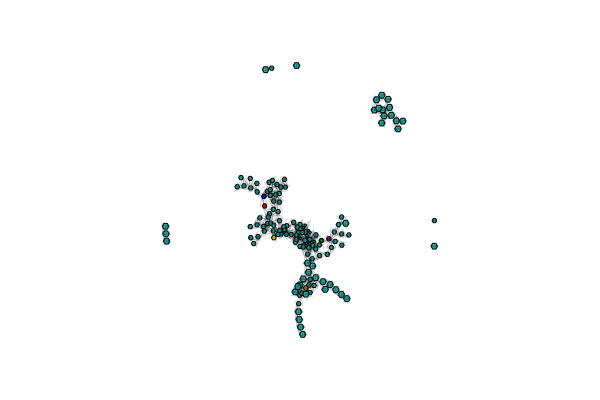

In [835]:
edgelabel_dict = Dict()
for i in 1:n
    for j in 1:n
        edgelabel_dict[(i, j)] = D[i, j]
    end
end

# membership = [1,2,1,1,1,1,3,1]
nodecolor = [colorant"lightseagreen", colorant"orange", colorant"yellow", colorant"red", colorant"blue", colorant"purple", colorant"green"]
# membership color
nodefillc = nodecolor[membership]

# # nodes size proportional to their degree
# nodesize = [Graphs.outdegree(g, v) for v in Graphs.vertices(g)]
# gplot(g, nodesize=nodesize)

graph = graphplot(Adj, names=1:n, curvature_scalar=0.06, markersize=0.2, fontsize=2, markercolor=nodefillc,           linecolor = :darkgrey,
           linealpha = 0.2, curves=false)

Start and end colour labels: <br>
 **_Orange: $n_{i1}$ Yellow: $n_{e1}$ <br> Red: $n_{i2}$ Blue: $n_{e2}$ <br> Purple: $n_{i3}$ Green: $n_{e3}$_**

### Defining edge costs, rider intake, and flow vector:

In [836]:
temp_D = D.*Adj
temp_r = zeros((n,n))

for i = 1:n
        temp_r[i, :] = r.*Adj[i, :]
end

d_e = zeros(0)
r_e = zeros(0)

for i = 1:n
    for j = 1:n
        if temp_D[i, j] != 0
            append!(d_e, temp_D[i, j])
        end
        if temp_r[i, j] != 0
            append!(r_e, temp_r[i, j])
        end
    end    
end

### Defining non-cyclic constraints:

In [837]:
cyc1 = floor.((Inc.+1)./2)
cyc2 = -1*ceil.((Inc.-1)./2)
;


**Decision variable:** <br>

$x$: all possible edges in the network, length = $e$ <br>
    $$ x =   \left\{
\begin{array}{ll}
      1 & \text{If the bus travels on that edge}  \\
      0 & \text{If the bus doesn NOT travel on that edge} \\
\end{array} 
\right.  $$

**Objective function:** <br>
$$ \max_{x} \text{    }r_e \cdot x$$

**Constraints:** <br>
  s.t. 
$$ \text{Inc}*x = b, $$
$$ d_e \cdot x <= f  $$


Rabeeya: Will add updated constraints later

## 4. Code Implementation

In [838]:
using LinearAlgebra, Ipopt, Gurobi
bus_route = Model(with_optimizer(Gurobi.Optimizer,OutputFlag=0, NonConvex = 2))

num_buses = 3

@variable(bus_route, X[1:e, 1:num_buses], Bin) # binary decision variable x that maps out the [path]

for i in 1:num_buses
    @constraint(bus_route, Inc*X[:, i] .== b[:, i]) # nodal conservation
    @constraint(bus_route, d_e'*X[:, i] <= f[i]) # fuel constraint
    @constraint(bus_route, cyc1*X[:, i] .<= 1) # can leave from one node once only
    @constraint(bus_route, cyc2*X[:, i] .<= 1) # can enter one node once only
    #@constraint(bus_route, cyc1*X[:, i] + cyc2*X[:, i] .<= 2) # can enter one node once only
end


for i in 1:num_buses
    for j in 1:num_buses
        if i != j
            @constraint(bus_route, dot(X[:, i],X[:, j]) <= 0.9) # not share path
        end
    end
end

@objective(bus_route, Max, sum(r_e'*X[:, i] for i in 1:num_buses))  # maximize people getting on the bus
    
s = optimize!(bus_route)

termination_status(bus_route)
#print(bus_route)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-03-15
Set parameter NonConvex to value 2


OPTIMAL::TerminationStatusCode = 1

## 5. Results and Analysis

### Defining dictionary for converting edge index to path:

In [839]:
edgeIndex2path = Dict()
count = 1
for i = 1:n
    for j = 1:n
        if Adj[i, j] != 0
            edgeIndex2path[count] = (i, j)
            count = count + 1
        end
    end
end

sorted_edges = sort(collect(pairs(edgeIndex2path)), by=x->x[1])

for i in sorted_edges
    println(i)
end

Pair{Any, Any}(1, (1, 2))
Pair{Any, Any}(2, (1, 7))
Pair{Any, Any}(3, (2, 3))
Pair{Any, Any}(4, (2, 10))
Pair{Any, Any}(5, (3, 4))
Pair{Any, Any}(6, (3, 8))
Pair{Any, Any}(7, (3, 36))
Pair{Any, Any}(8, (4, 2))
Pair{Any, Any}(9, (4, 5))
Pair{Any, Any}(10, (5, 6))
Pair{Any, Any}(11, (5, 31))
Pair{Any, Any}(12, (5, 37))
Pair{Any, Any}(13, (6, 2))
Pair{Any, Any}(14, (6, 7))
Pair{Any, Any}(15, (6, 20))
Pair{Any, Any}(16, (6, 31))
Pair{Any, Any}(17, (6, 37))
Pair{Any, Any}(18, (7, 8))
Pair{Any, Any}(19, (7, 20))
Pair{Any, Any}(20, (7, 30))
Pair{Any, Any}(21, (8, 9))
Pair{Any, Any}(22, (9, 10))
Pair{Any, Any}(23, (9, 21))
Pair{Any, Any}(24, (11, 12))
Pair{Any, Any}(25, (11, 17))
Pair{Any, Any}(26, (11, 28))
Pair{Any, Any}(27, (12, 13))
Pair{Any, Any}(28, (12, 35))
Pair{Any, Any}(29, (13, 14))
Pair{Any, Any}(30, (14, 15))
Pair{Any, Any}(31, (14, 27))
Pair{Any, Any}(32, (14, 31))
Pair{Any, Any}(33, (14, 37))
Pair{Any, Any}(34, (15, 13))
Pair{Any, Any}(35, (16, 17))
Pair{Any, Any}(36, (18, 1))
P

### Finding the optimal path taken:

In [840]:
function path_taken(opt_path)
    # finding edges travelled using edgeIndex2path dictionary
    path_taken_x = zeros(0)
    path_taken_y = zeros(0)
    for i = 1:e
        if opt_path[i] != 0
            temp = edgeIndex2path[i]
            append!(path_taken_x, temp[1] )
            append!(path_taken_y, temp[2] )
        end
    end
    travelled_edges_dict = Dict()
    # defining dictionary with 1 for travelled edges, 0 for untravelled edges
    for k = 1:length(path_taken_x)
        for i in 1:n
            for j in 1:n
                if i == path_taken_x[k] && j == path_taken_y[k] 
                    travelled_edges_dict[(i, j)] = 1
                elseif haskey(travelled_edges_dict, (i, j))
                    if travelled_edges_dict[(i, j)] == 1
                        travelled_edges_dict[(i, j)] = 1
                    end
                else 
                    travelled_edges_dict[(i, j)] = 0
                end
            end
        end
    end

    # printing the edges travelled on

    print("The bus travelled on these edges: \n")
    for i = 1:n
        for j = 1:n
            if travelled_edges_dict[(i, j)] != 0
                println((i, j))
            end
        end
    end
return travelled_edges_dict
end

path_taken (generic function with 1 method)

# For Naman: Change index here to see path taken for different buses:

In [859]:
opt_path = value.(X)
num_buses = 3
dicts = []

for i in 1:num_buses
    dict1 = path_taken(opt_path[:, i])
    push!(dicts, dict1)
end

The bus travelled on these edges: 
(1, 2)
(2, 3)
(3, 36)
(4, 5)
(5, 6)
(6, 31)
(14, 37)
(18, 1)
(19, 14)
(22, 4)
(31, 32)
(32, 33)
(33, 34)
(34, 22)
(36, 41)
(37, 18)
(41, 42)
(42, 43)
(43, 90)
(90, 63)
(94, 98)
(95, 111)
(96, 97)
(97, 95)
(98, 99)
(99, 100)
(100, 101)
(101, 102)
(102, 103)
(103, 104)
(104, 96)
(105, 106)
(106, 19)
(111, 105)
The bus travelled on these edges: 
(1, 7)
(7, 30)
(13, 14)
(14, 15)
(15, 13)
(18, 19)
(19, 25)
(21, 34)
(25, 26)
(26, 27)
(27, 1)
(30, 31)
(31, 18)
(34, 36)
(36, 37)
(37, 38)
(38, 21)
(44, 52)
(52, 90)
(56, 57)
(90, 44)
(94, 95)
(95, 96)
(96, 94)
The bus travelled on these edges: 
(3, 8)
(8, 9)
(9, 21)
(12, 13)
(14, 27)
(18, 14)
(20, 37)
(21, 22)
(22, 41)
(27, 18)
(31, 20)
(37, 31)
(41, 3)
(43, 68)
(51, 52)
(52, 43)
(53, 54)
(54, 55)
(55, 84)
(59, 78)
(60, 59)
(68, 69)
(69, 90)
(78, 79)
(79, 51)
(81, 82)
(82, 83)
(83, 60)
(84, 53)
(90, 81)
(130, 131)
(131, 132)
(132, 133)
(133, 130)


In [842]:
dicts[1]

Dict{Any, Any} with 19044 entries:
  (8, 138)   => 0
  (17, 12)   => 0
  (125, 10)  => 0
  (136, 118) => 0
  (22, 9)    => 0
  (48, 61)   => 0
  (66, 27)   => 0
  (97, 23)   => 0
  (40, 28)   => 0
  (107, 3)   => 0
  (64, 82)   => 0
  (12, 126)  => 0
  (52, 32)   => 0
  (25, 73)   => 0
  (91, 30)   => 0
  (30, 23)   => 0
  (100, 10)  => 0
  (117, 92)  => 0
  (63, 110)  => 0
  (101, 14)  => 0
  (8, 63)    => 0
  (85, 77)   => 0
  (73, 106)  => 0
  (58, 98)   => 0
  (41, 85)   => 0
  ⋮          => ⋮

### Finding nodes travelled:

In [843]:
function nodes_travelled(opt_path, bus_no)
    nodes = 1:n
    opt_path_bus = opt_path[:, bus_no]
    temp_path = zeros((n,n))

    # defining temporary variable temp_path to store nodes travelled to for on each edge index
    # (zeros need to be filtered out) 
    for i = 1:n
            temp_path[i, :] = nodes.*Adj[i, :]
    end

    path = zeros(0)

    # filtering out zeros
    for i = 1:n
        for j = 1:n
            if temp_path[i, j] != 0
                append!(path, temp_path[i, j])
            end
        end    
    end


    # finding actual nodes travelled to using optimal edge vector x
    temp_path = path.*opt_path_bus


    path = zeros(0)

    # filtering out zeros again
    for p in temp_path
        if p != 0
            append!(path, p)
        end
    end

    # defining membership based on nodes travelled to, 1 for not travelled to, 2 for travelled to
    for i = 1:n
        for p in path 
            if round(Int, p) == i
                membership[i] = bus_no + 1
            end
        end
    end

    # start node is also travelled to 
    membership[n_i[bus_no]] = bus_no + 1
end

nodes_travelled (generic function with 1 method)

In [844]:
membership = ones(n)
for i in 1:num_buses
    nodes_travelled(opt_path, i)
end

# convert to int for indexing
for i = 1:n
    membership[i] = convert(Int, membership[i])
end

# assigning colours, yellow for travelled to, seagreen for not
int_membership = Int.(membership)
nodecolor = [colorant"white", colorant"orange", colorant"yellow", colorant"blue"]
nodefillc = nodecolor[int_membership]
;

In [872]:

all_sources = []
for i in sorted_edges
    source = i[2][1]
    sink = i[2][2]
    x = lat[source], long[source], lat[sink], long[sink], source, sink
    
    push!(all_sources, x)
    
end


travelled_edges1 = []

sources = Dict()


sources[1] = all_sources

idx = 2
for dict in dicts
    
    loc = []
    for (key, value) in dict
        if value != 0
            i = key
            source = i[1]
            sink = i[2]
            x = lat[source], long[source], lat[sink], long[sink], source, sink
            push!(loc, x)
        end
    end
    sources[idx] = loc
    idx +=1
end

A = sources


for (k,v) in A
    CSV.write("Connections"* string(k)*".csv",  DataFrame(v), writeheader=["start_lat", "start_lon", "end_lat", "end_lon", "start_node", "end_node"])
end


busstops = []

count = 1
busstops = []

for x in stop_locations
    push!(busstops, (count, x.lat, x.lon))
    count+=1
end

B = busstops[1:N-2]

CSV.write("BusStops.csv", DataFrame(B), writeheader=["node", "lon", "lat"])

4Any[(43.073913, -89.397473, 43.071827, -89.397315, 41, 3), (43.063945, -89.512543, 43.079964, -89.509348, 131, 132), (43.07408, -89.406253, 43.075047, -89.406479, 37, 31), (43.0874, -89.359165, 43.088874, -89.357781, 59, 78), (43.074837, -89.396803, 43.073913, -89.397473, 22, 41), (43.073505, -89.407051, 43.073506, -89.409433, 18, 14), (43.074849, -89.3914, 43.074837, -89.396803, 21, 22), (43.054058, -89.39913, 43.062942, -89.404119, 12, 13), (43.083716, -89.362013, 43.085865, -89.360575, 83, 60), (43.079964, -89.509348, 43.075419, -89.507475, 132, 133), (43.070914, -89.399689, 43.074073, -89.392419, 8, 9), (43.07279, -89.381014, 43.081232, -89.365346, 81, 82), (43.091766, -89.355489, 43.080257, -89.366954, 54, 55), (43.080257, -89.366954, 43.078962, -89.368721, 55, 84), (43.071827, -89.397315, 43.070914, -89.399689, 3, 8), (43.074933, -89.386107, 43.076388, -89.381564, 68, 69), (43.078962, -89.368721, 43.077878, -89.370083, 84, 53), (43.088874, -89.357781, 43.07695, -89.373573, 78, 7

### Plotting final network:
Yellow bus stops: are included in route
Seagreen bus stops: are NOT included in route
Paths with 1: are included in route
Paths with 0: are NOT included in route

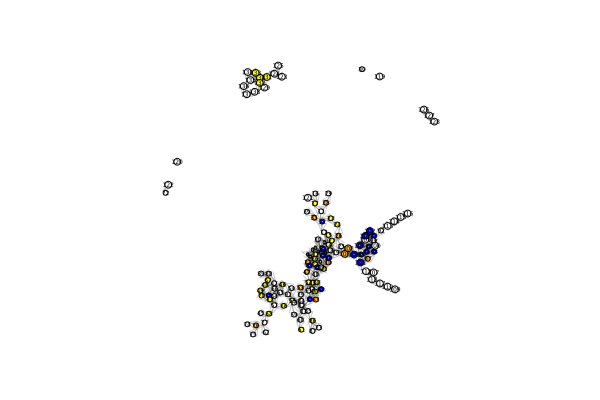

In [815]:
# edges are 1 for travelled on, 0 for not travelled on
# import Pkg; Pkg.add("NetworkLayout")
using NetworkLayout
using Graphs
using GraphPlot

# g = Graphs.Grid((12,12))

g = Graphs.Grid((121,121))
layout = SquareGrid(cols=121)
# layout = NetworkLayout.squaregrid(Int.(Adj))
nodesize = [Graphs.outdegree(g, v) for v in Graphs.vertices(dirGraph)]
nodesize=nodesize

# graph = graphplot(Adj, nodesize=nodesize, names=1:n, nodeshape=:circle, fontsize=4, edgelabel=travelled_edges_dict, markersize=0.1, markercolor=nodefillc,linecolor = :darkgrey,
           # linealpha = 0.2, curves=false)

layout=(args...)->spring_layout(args...; C=10)
# gplot(g, layout=layout, nodelabel=nodelabel)

graph = graphplot(Adj, nodesize=nodesize, names=1:n, nodeshape=:circle, fontsize=4, edgelabel=travelled_edges_dict, markersize=0.1, markercolor=nodefillc,linecolor = :darkgrey,
           linealpha = 0.2, curves=false, nlabels_distance=1)

# gplot(dirGraph,nodesize=nodesize, layout=layout, nodelabel=1:n, edgelabel=travelled_edges_dict, nodefillc=nodefillc)

In [816]:
path_taken

path_taken (generic function with 1 method)

### Fuel used, and people picked up:

In [817]:
println("Fuel used: ", dot(d_e, opt_path))
println("People picked up: ", dot(r_e, opt_path) + r[n_i]) 

LoadError: DimensionMismatch("dot product arguments have lengths 225 and 675")

# Next Steps

Next, we will work on improving the mathematic model and show the solution to the optimization problem via suitable plots. 

* **Merge the optimization model with bus data**: We will further analyze the real bus network of Madison and utilize the full dataset of Madison metro transit to develop the model.  

* **Include reasonable estimations of unknown constraint variables**: We will include estimates of fuel value (considering the distances matrix), start and end nodes (considering the network map). 

* **Run X different buses simultaneously**: We will run X (around ~three) different buses simultaneously in the Madison bus system. We will ideally want that these bus routes do not overlap (or try and minimize overlap).

* **Cycle constraint**: We want to make sure that no cycles exists in the network, for this we will have to add a constraint such that no bus travels on the same edge/path twice.

* **Bus capacity constraint**: Currently we're assuming that the number of people entering and leaving the bus are always equal so we aren't taking into account bus capacity, and we aren't keeping track of passengers at evert bus stop. It will be interesting to see if we can implement a probability function for people leaving at a bus stop, and then use that to place a limit on the bus capacity. Which will limit the number of people we can take up at each bus stop. 

* **Sensitvity analysis:** Once we have our final results, we want to do a sensitivity analysis to analyze the fuel and capacity constraints.  